# Orbital analysis

This section process the preliminary vibration data in different load condition of three bearings on hydropower plant.

In [2]:
# import all necessary packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import time
from scipy.signal import butter, buttord, sosfreqz, sosfilt, sosfiltfilt, cheb2ord, cheby2, firwin, freqz, firls, lfilter, iirpeak
from scipy.fft import rfft, irfft, fftfreq

In [3]:
# load the vibration data : 
# 1. High load operational condition on Larona Unit #1 on August 10th, 2023 at 1:00:00 a.m. ; clockwise ; top ; X:0° EU Y:+90° EU 
# 2. Low load operational condition on Larona Unit #1 on October 25th, 2023 at 6:00:00 p.m. ; clockwise ; top ; X:0° EU Y:+90° EU 
# 3. Normal load operational condition on Larona Unit #1 on October 8th, 2023 at 1:00:00 a.m. ; clockwise ; top ; X:0° EU Y:+90° EU 

db_data_hl = pd.read_excel("LGS1_VibrationOrbit_2023_HighLoad.xlsx", sheet_name="Orbit Comparison")
db_data_nl = pd.read_excel("LGS1_VibrationOrbit_2023_NormalLoad.xlsx", sheet_name="Orbit Comparison")
db_data_ll = pd.read_excel("LGS1_VibrationOrbit_2023_LowLoad.xlsx", sheet_name="Orbit Comparison")

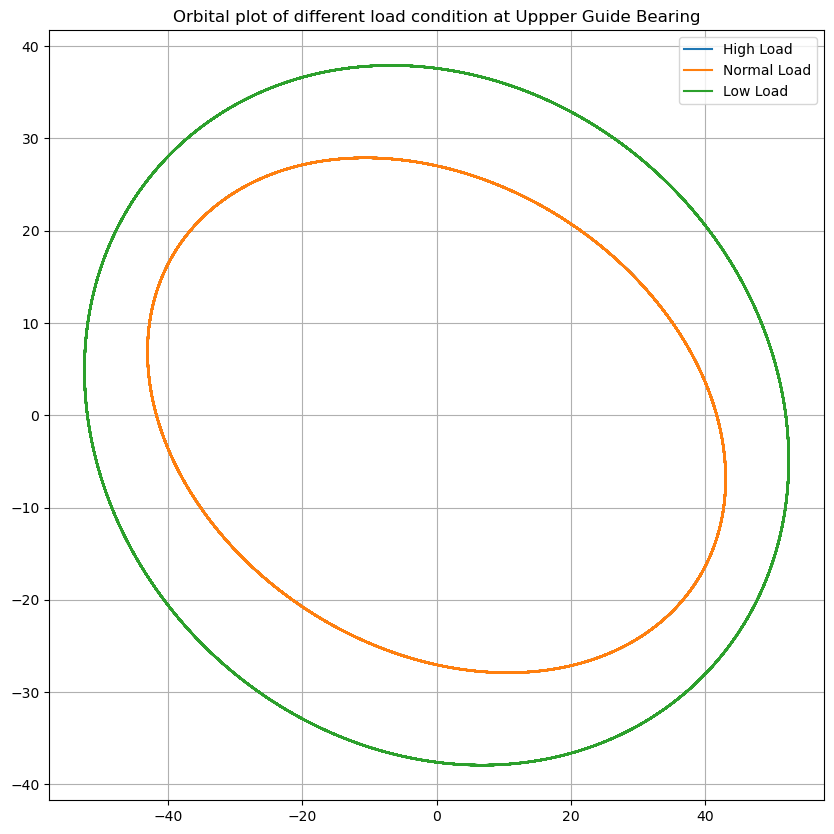

In [4]:
# create and plot the vibration data
ugb_hl_1x_time = db_data_hl['UGB – Time – 1X']
ugb_hl_1x_x = db_data_hl['UGB – Disp – 1X – X']
ugb_hl_1x_y = db_data_hl['UGB – Disp – 1X – Y']

ugb_nl_1x_time = db_data_nl['UGB – Time – 1X']
ugb_nl_1x_x = db_data_nl['UGB – Disp – 1X – X']
ugb_nl_1x_y = db_data_nl['UGB – Disp – 1X – Y']

ugb_ll_1x_time = db_data_ll['UGB – Time – 1X']
ugb_ll_1x_x = db_data_ll['UGB – Disp – 1X – X']
ugb_ll_1x_y = db_data_ll['UGB – Disp – 1X – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(ugb_hl_1x_x, ugb_hl_1x_y)
ax.plot(ugb_nl_1x_x, ugb_nl_1x_y)
ax.plot(ugb_ll_1x_x, ugb_ll_1x_y)
ax.set_title("Orbital plot of different load condition at Uppper Guide Bearing")
ax.legend(['High Load', 'Normal Load', 'Low Load'])
plt.grid()

plt.show()   

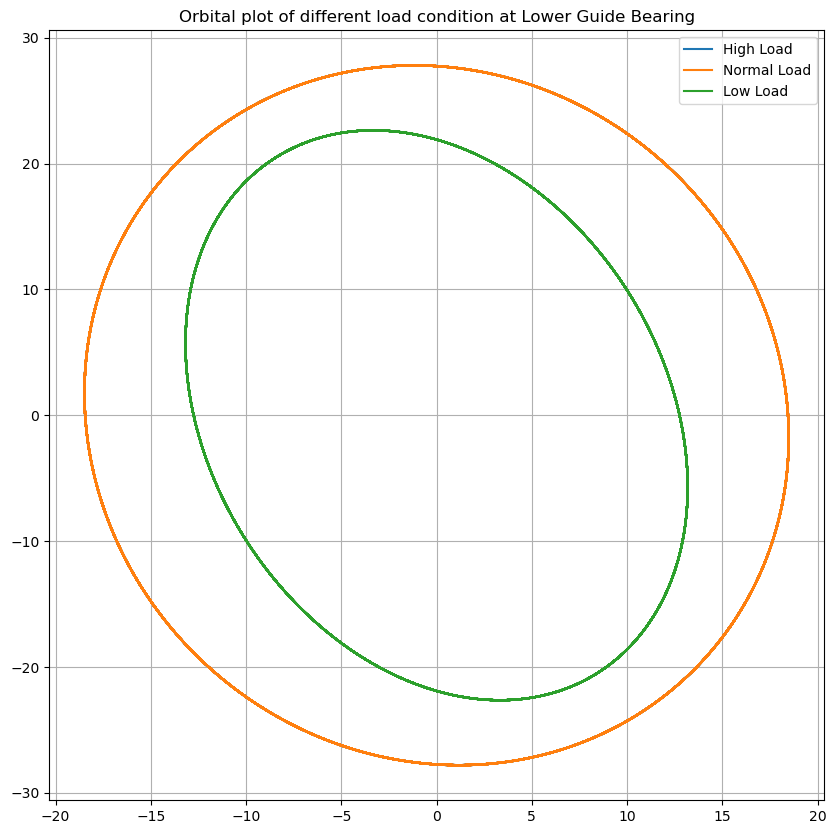

In [5]:
# create and plot the vibration data
lgb_hl_1x_time = db_data_hl['LGB – Time – 1X']
lgb_hl_1x_x = db_data_hl['LGB – Disp – 1X – X']
lgb_hl_1x_y = db_data_hl['LGB – Disp – 1X – Y']

lgb_nl_1x_time = db_data_nl['LGB – Time – 1X']
lgb_nl_1x_x = db_data_nl['LGB – Disp – 1X – X']
lgb_nl_1x_y = db_data_nl['LGB – Disp – 1X – Y']

lgb_ll_1x_time = db_data_ll['LGB – Time – 1X']
lgb_ll_1x_x = db_data_ll['LGB – Disp – 1X – X']
lgb_ll_1x_y = db_data_ll['LGB – Disp – 1X – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(lgb_hl_1x_x, lgb_hl_1x_y)
ax.plot(lgb_nl_1x_x, lgb_nl_1x_y)
ax.plot(lgb_ll_1x_x, lgb_ll_1x_y)
ax.set_title("Orbital plot of different load condition at Lower Guide Bearing")
ax.legend(['High Load', 'Normal Load', 'Low Load'])
plt.grid()

plt.show()  

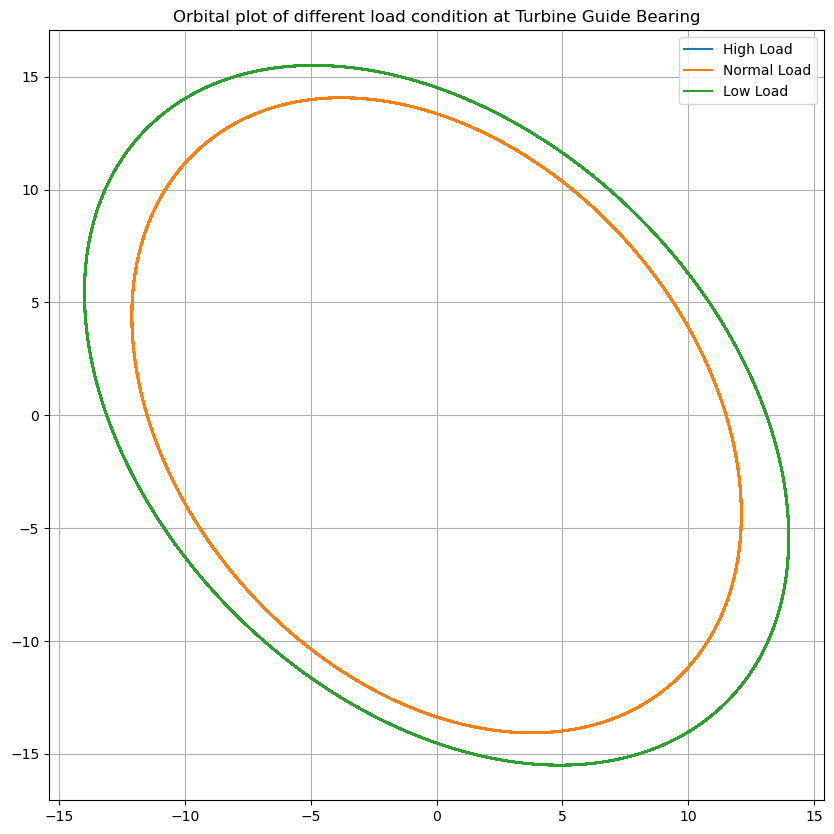

In [7]:
# create and plot the vibration data
tgb_hl_1x_time = db_data_hl['TGB – Time – 1X']
tgb_hl_1x_x = db_data_hl['TGB – Disp – 1X – X']
tgb_hl_1x_y = db_data_hl['TGB – Disp – 1X – Y']

tgb_nl_1x_time = db_data_nl['TGB – Time – 1X']
tgb_nl_1x_x = db_data_nl['TGB – Disp – 1X – X']
tgb_nl_1x_y = db_data_nl['TGB – Disp – 1X – Y']

tgb_ll_1x_time = db_data_ll['TGB – Time – 1X']
tgb_ll_1x_x = db_data_ll['TGB – Disp – 1X – X']
tgb_ll_1x_y = db_data_ll['TGB – Disp – 1X – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(tgb_hl_1x_x, tgb_hl_1x_y)
ax.plot(tgb_nl_1x_x, tgb_nl_1x_y)
ax.plot(tgb_ll_1x_x, tgb_ll_1x_y)
ax.set_title("Orbital plot of different load condition at Turbine Guide Bearing")
ax.legend(['High Load', 'Normal Load', 'Low Load'])
plt.grid()

plt.show()  

In [137]:
ugb_1x_rpm = db_data['UGB – RPM – 1X']
ugb_1x_freq = db_data['UGB – RPM – 1X'] / 60
ugb_1x_freq

ugb_ovr_rpm = db_data['UGB – RPM – Overall']
ugb_ovr_freq = db_data['UGB – RPM – Overall'] / 60
ugb_ovr_freq

0       4.569615
1       4.569615
2       4.569615
3       4.569615
4       4.569615
          ...   
4091    4.569615
4092    4.569615
4093    4.569615
4094    4.569615
4095    4.569615
Name: UGB – RPM – Overall, Length: 4096, dtype: float64

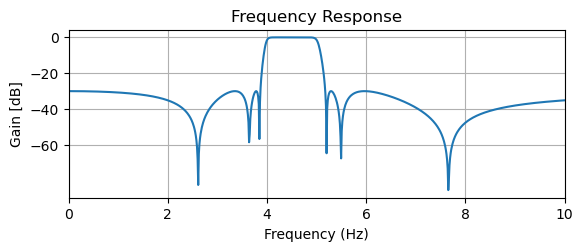

In [411]:
# filtering overall data into 1x, 2x, and 3x RPM data
fs = np.round(len(ugb_1x_time) / max(ugb_1x_time), 0)

dt = 1 / fs
fl = 4
fu = 5
transwidth = 0.2
f_band = np.array([fl, fu]) / (fs/2)
f_bands = [0, fl - transwidth, fl, fu, fu + transwidth, (fs/2)]
wp = [fl, fu]
ws = [fl - transwidth, fu + transwidth]

gpass = 1.5
gstop = 30
n, wn = buttord(wp, ws, gpass, gstop, fs=fs)
sos = butter(n, wn, 'bandpass', output='sos', fs=fs)

n, wn = cheb2ord(wp, ws, gpass, gstop, fs=fs)
sos = cheby2(n, 30, wn, 'bandpass', output='sos', fs=fs)

N = 16384
w,  h  = sosfreqz(sos, worN=N, fs=fs)

plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.xlim([0, 10])
plt.xlabel('Frequency (Hz)')

plt.show()

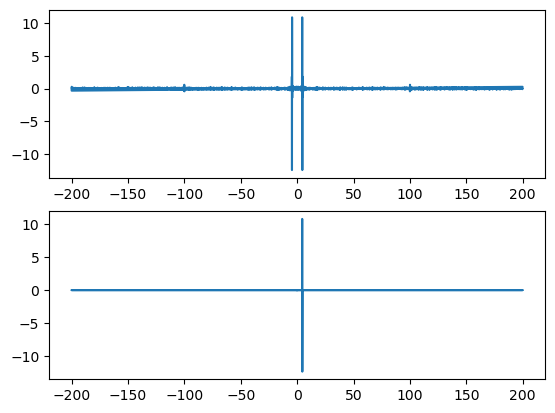

In [246]:
# apply filter FFT
def FFT_filter(time_data, signal, cut_off_frequency, fs):
    signal = signal - np.mean(signal)
    nfft = int(pow(2, np.ceil(np.log2(len(signal)))))
    win = np.hamming(len(signal))
    # freq = (fs/2) * np.arange(0,1,1/(nfft/2+1))
    freq = np.fft.fftfreq(signal.size, d=time_data[1]-time_data[0])
    
    ori_spectrum = 2/len(signal) * np.fft.fft(win*signal, nfft)

    # Select contents on the targetted frequencies
    new_spectrum = []
    for i in range(len(freq)):
        if freq[i] >= cut_off_frequency + 0.1 or freq[i] <= cut_off_frequency - 0.1:
            new_spectrum.append(0)
        else:
            new_spectrum.append(ori_spectrum[i])

    new_spectrum = np.array(new_spectrum)

    new_data = np.fft.ifft(new_spectrum / (1/len(signal)), nfft)
    # new_data = new_data[0:len(signal)]

    new_data = new_data / win

    return new_data, freq, ori_spectrum, new_spectrum, nfft

filtered_signal_x, freq, ori_spec, new_spec, nfft = FFT_filter(ugb_ovr_time, ugb_ovr_x, ugb_ovr_freq[0], fs)
filtered_signal_y, freq, ori_spec, new_spec, nfft = FFT_filter(ugb_ovr_time, ugb_ovr_y, ugb_ovr_freq[0], fs)

# plt.plot(ugb_ovr_time, filtered_signal_y)
plt.subplot(211)
plt.plot(freq, ori_spec)
plt.subplot(212)
plt.plot(freq, new_spec)
plt.show()


Text(0.5, 0, 'Frequency (Hz)')

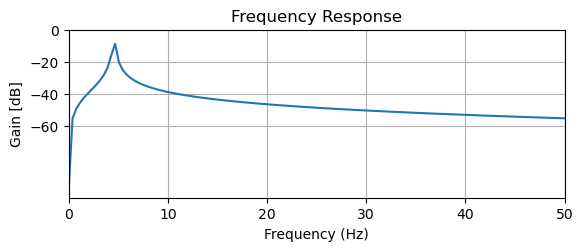

In [381]:
# apply low pass filter
cut_off_frequency = ugb_ovr_freq[0]
b, a = iirpeak(cut_off_frequency, 50, fs=400)
filtered_signal_x = filtfilt(b, a, ugb_ovr_x)
filtered_signal_y = filtfilt(b, a, ugb_ovr_y)

w, h = freqz(b,a, fs=400)

plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.xlim([0, 50])
plt.xlabel('Frequency (Hz)')

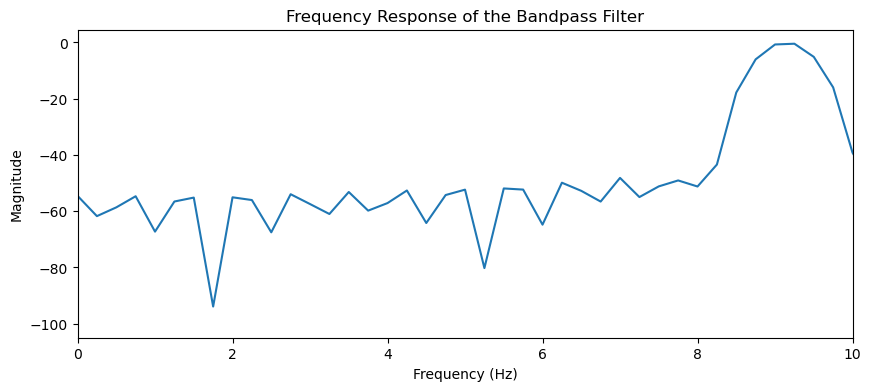

In [408]:
def bandpass_filter(signal, lowcut, highcut, fs):
    order = 1024
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b = firwin(order, [low, high], pass_zero=False)
    
    filtered_signal = filtfilt(b, 1, signal)

    w, h = freqz(b, 1, worN=2*fs, fs=fs)
    delay = 0.5 * (order-1) / fs
    
    return filtered_signal, w, h, delay

# Example usage
fs = 400  # Sample rate of the signal
f0 = ugb_ovr_freq[0]   # Desired frequency to pass
lowcut = 2*f0 - 0.25  # Lower cutoff frequency
highcut = 2*f0 + 0.25 # Upper cutoff frequency

# Apply bandpass filter
filtered_signal_x, w, h, delay = bandpass_filter(ugb_ovr_x, lowcut, highcut, fs)
filtered_signal_y, w, h, delay = bandpass_filter(ugb_ovr_y, lowcut, highcut, fs)

# Plot frequency response of the filter
plt.figure(figsize=(10, 4))
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,10)
plt.title('Frequency Response of the Bandpass Filter')
plt.show()

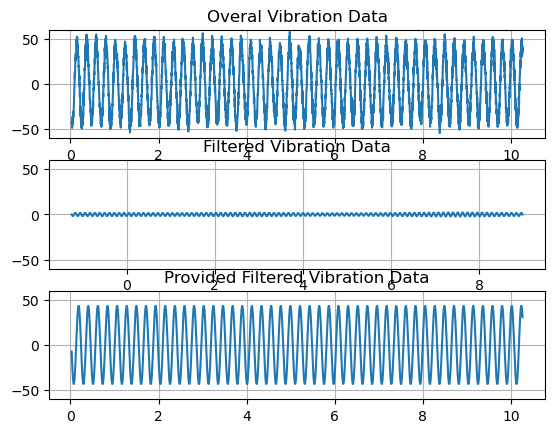

In [409]:
# Filtering the raw data and compare with the provided preliminary data
#filtered_signal_x = sosfiltfilt(sos, ugb_ovr_x)
#filtered_signal_y = sosfiltfilt(sos, ugb_ovr_y)

plt.subplot(3, 1, 1)
plt.plot(ugb_ovr_time, ugb_ovr_x)
plt.grid(True)
plt.ylim([-60, 60])
plt.title("Overal Vibration Data")

plt.subplot(3, 1, 2)
plt.plot(ugb_ovr_time - delay, filtered_signal_x)
plt.grid(True)
plt.ylim([-60, 60])
plt.title("Filtered Vibration Data")

plt.subplot(3, 1, 3)
plt.plot(ugb_ovr_time, ugb_1x_x)
plt.grid(True)
plt.ylim([-60, 60])
plt.title("Provided Filtered Vibration Data")

plt.show()

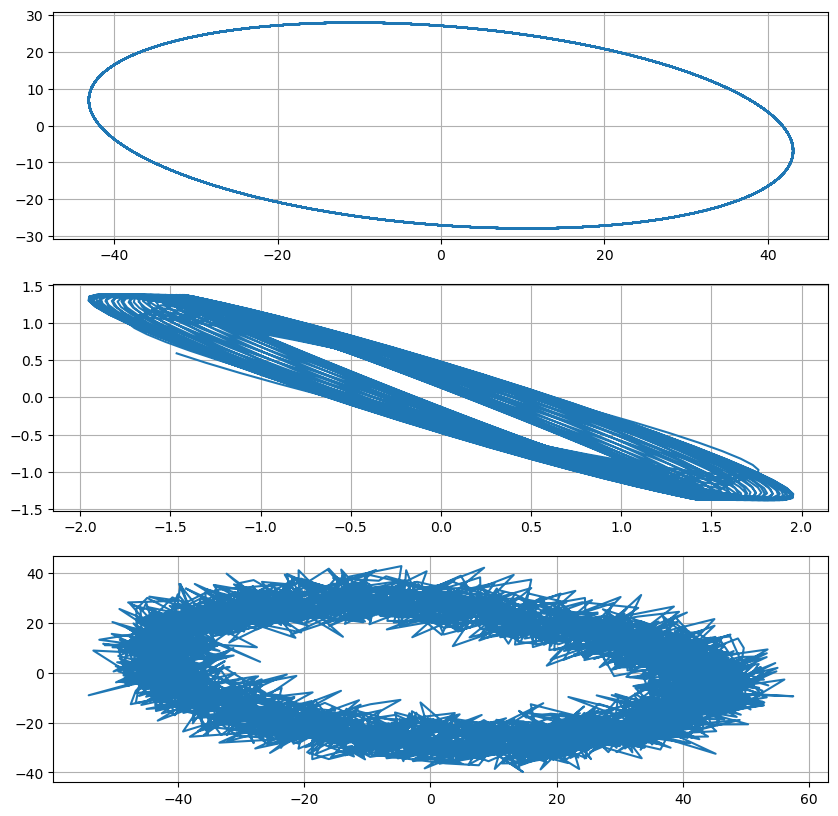

In [410]:
# extract and analyze the vibration data using orbital analysis

ugb_1x_time = db_data['UGB – Time – 1X']
ugb_1x_x = db_data['UGB – Disp – 1X – X']
ugb_1x_y = db_data['UGB – Disp – 1X – Y']

ugb_ovr_time = db_data['UGB – Time – Overall']
ugb_ovr_x = db_data['UGB – Disp – Overall – X']
ugb_ovr_y = db_data['UGB – Disp – Overall – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(ugb_1x_x, ugb_1x_y)
plt.grid()

ax2 = fig.add_subplot(312)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax2.plot(filtered_signal_x[1000:3000], filtered_signal_y[1000:3000])
plt.grid()

ax3 = fig.add_subplot(313)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax3.plot(ugb_ovr_x, ugb_ovr_y)
plt.grid()

plt.show()    

# 